© 2023 魏筱鋆 (Jessie Wei). All rights reserved.

# Task Requirements
- 完成京东平台“电小二”品牌任意一款热销产品评论分析，分析角度和方法自选。  
- 完成时间下周三之前（4月25日），提交形式：建议格式为PDF或Jupyter Notebook

### Data Source

- 数据来源：https://item.jd.com/45528625958.html#comment   
- 产品选择：电小二（Dxpower） 户外电源600W大功率220V移动便携大容量电脑充电宝露营应急备用储能电源   
- 型号选择：户外电源500W
- 爬取到的数据维度：**用户ID, 评论内容, 购买时间, 点赞数, 回复数, 得分, 评价时间**

In [225]:
%load_ext dmind
%dmindheader

The dmind extension is already loaded. To reload it, use:
  %reload_ext dmind


### 分析角度
**思路**：由于爬取的评论数据量较少（1000条左右），暂不考虑使用<u>**预训练模型**</u>进行分析

In [226]:
%%dmind text

数据挖掘
    1- 数据预处理
        1.1 处理评论缺失和去重 
        1.2 评论清洗  
    2- 数据分析可视化
        2.1 购买时间分布  
        2.2 购买时间和得分的关系
        2.3 交互特征（点赞数）的数量分布
    3-情感分类和情感关键词挖掘
        3.1 情感分类-SnowNLP  
        3.2 情感分类后关键词挖掘-词云图  
    4- 关键信息提取
        4.1 TextRank关键词提取
        4.2 LDA主题分析
    5- 共现语义网络
        5.1 词频统计
        5.2 构建语义关联矩阵
        5.3 绘制语义网络图
    6- 总结和其他潜在分析角度

In [227]:
# 导入所需库
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import itertools
import re
import os
import pickle
import jieba
import jieba.analyse

import warnings
warnings.filterwarnings('ignore')

## 1- 数据预处理

In [228]:
# 加载评爬取的评论数据
df = pd.read_csv('data/scraped_Dxpower_JDComment_data.csv')
df[:2] # 包括：用户ID,评论内容,购买时间,点赞数,回复数,得分,评价时间,商品型号

,用户ID,评论内容,购买时间,点赞数,回复数,得分,评价时间,商品型号
0,18634286980,关注很久了，户外钓鱼用来很方便，容量大，本以为这个很重，没想到很轻，携带方便，出去玩再也不担...,2022-12-10 20:25:34,1,1,5,2023-01-01 10:50:01,电小二（Dxpower） 户外电源600W大功率220V移动便携大容量电脑充电宝露营应急备用...
1,18331172008,宝贝特别喜欢，颜值高质量好，中看又中用，有需要的朋友不要犹豫了，最后祝商家生意兴隆！,2022-10-24 00:00:58,0,1,5,2022-11-04 19:58:58,电小二（Dxpower） 户外电源600W大功率220V移动便携大容量电脑充电宝露营应急备用...


In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   用户ID    1002 non-null   int64 
 1   评论内容    1002 non-null   object
 2   购买时间    1002 non-null   object
 3   点赞数     1002 non-null   int64 
 4   回复数     1002 non-null   int64 
 5   得分      1002 non-null   int64 
 6   评价时间    1002 non-null   object
 7   商品型号    1002 non-null   object
dtypes: int64(4), object(4)
memory usage: 62.8+ KB


### 1.1- 处理评论缺失和去重 

In [230]:
df = df.dropna(subset=['评论内容'], how='any') # 删除"评论内容“列中的空值
df = df.drop_duplicates(subset=['评论内容'], keep='first') # 评论去重
df.reset_index(drop=True,inplace=True) # 重置索引
df.shape

(992, 8)

### 1.2- 评论清洗 

In [231]:
# 删除“京东”，“京东商城”，“京东自营”等对目标产品分析无关的词
pattern = re.compile('京东|京东商城|京东自营')
df['评论内容'] = df['评论内容'].str.replace(pattern, '')

In [232]:
# 压缩叠词
def condense(str):
    # 这里i代表每次处理的字符单位数，如i=1时处理“好好好好”的情况，i=2时处理“很好很好很好”的情况
    # i=1&i=2时用一种处理方式，即当重复数量>2时才进行压缩，因为出现“滔滔不绝”、“美的的确好”
    # 跟“容我思考思考”“这真的真的好看”等不好归为冗余的情况。但当出现3次及以上时基本就是冗余了。
    for i in [1, 2]:
        j = 0
        while j < len(str)-2*i:
            #判断重复了至少两次
            if str[j: j+i] == str[j+i: j+2*i] and str[j: j+i] == str[j+2*i: j+3*i]:
                k = j+2*i
                while k+i<len(str) and str[j: j+i]==str[k+i: k+2*i]:
                    k += i
                str = str[: j+i] + str[k+i:]
            j += 1
        i += 1

    # i=3&i=4时用一种处理方式，当重复>1时就进行压缩，因为3个字以上时重复不再构成成语或其他常用语，
    # 基本上即使冗余了。因为大于五个字的重复比较少出现，为了减少算法复杂度可以只处理到i=4。
    for i in [3, 4, 5]:
        j = 0
        while j < len(str)-2*i:
        #判断重复了至少一次
            if str[j: j+i]==str[j+i: j+2*i]:
                k = j+i
                while k+i<len(str) and str[j: j+i]==str[k+i: k+2*i]:
                    k += i
                str = str[: j+i] + str[k+i:]
            j += 1
        i += 1

    return str

In [233]:
df['评论内容'] = df['评论内容'].astype('str').apply(lambda x: condense(x))  # 去除重复词

In [234]:
txt_list = df['评论内容'].tolist()

In [235]:
# 把评论内容导出，便于复用
with open('data/comment.txt', 'w', encoding='utf-8') as f:
    for line in txt_list:
        f.write(line + '\n')

## 2- 数据分析可视化

### 2.1 购买时间分布

**探究哪一个月份的购买人数最多**

In [236]:
df['购买时间'] = pd.to_datetime(df['购买时间']).dt.strftime('%Y-%m')
df1=pd.DataFrame(df['购买时间'].value_counts())
df1.columns=['counts']
df1.head(3)

,counts
2021-11,59
2021-06,51
2019-06,45


In [237]:
import pyecharts.options as opts
from pyecharts.charts import Scatter

df1.columns=['counts']
df1['index']=df1.index

scatter = (
    Scatter()
    .add_xaxis(df1['index'].tolist())
    .add_yaxis("", df1['counts'].tolist(), symbol_size=20)
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
    .set_global_opts(title_opts=opts.TitleOpts(title="购买时间散点图"),
                     xaxis_opts=opts.AxisOpts(name="购买时间", axislabel_opts=opts.LabelOpts(rotate=-45)),
                     yaxis_opts=opts.AxisOpts(name="购买人数"))
)

scatter.render_notebook()

**购买时间主要集中在每年大促期间，即11月和6月。**

### 2.2 购买时间和得分的关系

In [238]:
from sklearn.preprocessing import MinMaxScaler # 用来对得分数据做归一化，因为绝大的得分为4或5
from pyecharts.charts import Line

In [239]:
# 按照月份统计平均评价得分
score_means = df.groupby(df['购买时间'])['得分'].mean()

# 因为评价得分大多为4或5分，对得分进行归一化，即得分取值为[0,1]
scaler = MinMaxScaler()
normalized_score = scaler.fit_transform(score_means.values.reshape(-1, 1))
normalized_score = normalized_score.round(2) # 保留位小数

# 绘制平均评价得分折线图
line = (
    Line()
    .add_xaxis(list(score_means.index))
    .add_yaxis("平均评价得分", list(normalized_score.flatten()))
    .set_global_opts(
        xaxis_opts=opts.AxisOpts(name="购买时间"),
        yaxis_opts=opts.AxisOpts(name="平均评价得分"),
        title_opts=opts.TitleOpts(title="用户购买时间与得分的关系")
    )
)
line.render_notebook()  

**在通过对得分进行归一化之后，发现**  
- **用户的评价得分商品在大促期间（如6，10，11月）下降明显。结合后文负面情绪关键词挖掘的结果，暗示在大促期间，由于商品发货量大，客服售后应对不及时，难免出现中差评，这会影响卖家DSR动态评分的高低。**

### 2.3 交互特征（点赞数）的数量分布

<AxesSubplot:ylabel='点赞数'>

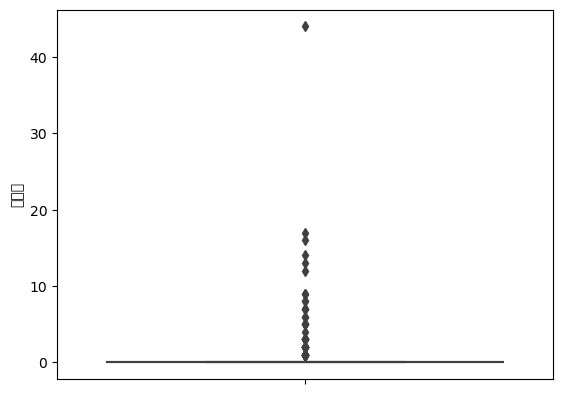

In [240]:
sns.boxplot( y=df['点赞数'] )

<AxesSubplot:xlabel='点赞数', ylabel='Density'>

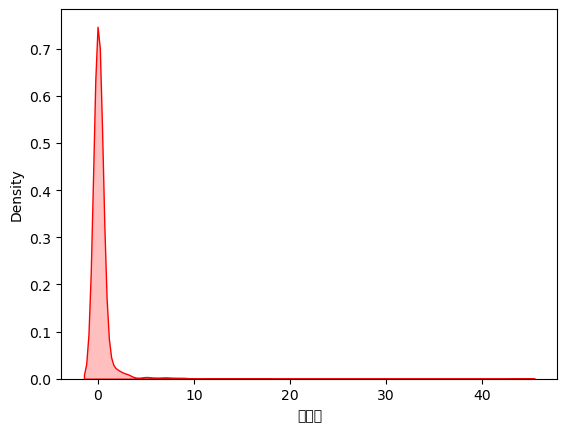

In [241]:
sns.kdeplot(df['点赞数'], color="Red", shade = True)

In [242]:
print("最大点赞数: " + str(np.max(df['点赞数'])))
print("平均点赞量: " + str(np.mean(df['点赞数'])))

最大点赞数: 44
平均点赞量: 0.31451612903225806


**发现评论的点赞数主要集中在0-4之间，最大点赞数为44，平均点赞量为0.314。**

## 3-情感分类和情感关键词挖掘

### 3.1 情感分类-SnowNLP

In [243]:
from snownlp import SnowNLP
from pyecharts.charts import Bar, Pie, Line
from pyecharts import options as opts

**经过人工判别，发现3分得分以上的的评论多为称赞，持鼓励态度。判定3分为情感极性分界线（即>3分为“积极”）， 提取正向评论的特征 'pos'**

In [244]:
def pos(x):
    if x>3:
        return 1
    else:
        return 0
df['积极']=df['得分'].apply(pos)
y_pred=df['积极'].values
df.head(2)

,用户ID,评论内容,购买时间,点赞数,回复数,得分,评价时间,商品型号,积极
0,18634286980,关注很久了，户外钓鱼用来很方便，容量大，本以为这个很重，没想到很轻，携带方便，出去玩再也不担...,2022-12,1,1,5,2023-01-01 10:50:01,电小二（Dxpower） 户外电源600W大功率220V移动便携大容量电脑充电宝露营应急备用...,1
1,18331172008,宝贝特别喜欢，颜值高质量好，中看又中用，有需要的朋友不要犹豫了，最后祝商家生意兴隆！,2022-10,0,1,5,2022-11-04 19:58:58,电小二（Dxpower） 户外电源600W大功率220V移动便携大容量电脑充电宝露营应急备用...,1


**使用SnowNLP对文本内容进行情感分析**

In [245]:
# 定义一个空的情感分析结果列表
sentiment_scores = []
for i in txt_list:
    s = SnowNLP(i)
    sentiment_scores.append(s.sentiments)

# 统计每个情感得分的数量
bins = np.arange(0, 1, 0.03)
bin_counts, _ = np.histogram(sentiment_scores, bins=bins)

# 将数据处理成echarts中bar图所需的格式
x_axis = bins[:-1].tolist()
y_axis = bin_counts.tolist()

# 绘制bar图
bar = Bar()
bar.add_xaxis(x_axis)
bar.add_yaxis('Quantity', y_axis)
bar.set_global_opts(title_opts = {"text": "Analysis of Sentiments"}, 
                    xaxis_opts = {"name": "Sentiments Probability"},
                    yaxis_opts = {"name": "Quantity"})
bar.render_notebook()

**SnowNLP的情感得分呈现两头分布，主要集中在0分和1分附近，中间分布较少，1分附近最多。**

In [246]:
# 定义一个空的积极和消极情感的文本列表
pos_list = []
neg_list = []

# 根据情感分数的分布情况和分数数量，判断阈值
threshold = 0.5
bins = [0] * 101
for score in sentiment_scores:
    bins[int(score * 100)] += 1
for i in range(100):
    positive_count = sum(bins[int(threshold * 100):])
    negative_count = sum(bins[:int(threshold * 100)])
    if positive_count > negative_count:
        break
    else:
        threshold -= 0.01

# 根据选定的阈值将情感分数进行二分类，并将文本分配到相应的列表中
for i, score in enumerate(sentiment_scores):
    if score >= threshold:
        pos_list.append(txt_list[i])
    else:
        neg_list.append(txt_list[i])


print('Threshold:', threshold)
print('Positive count:', len(pos_list))
print('Negative count:', len(neg_list))

Threshold: 0.5
Positive count: 782
Negative count: 210


In [247]:
# 示例数据
cate = ['positive','negative']
data = [782, 210]

pie = (Pie()
       .add('', [list(z) for z in zip(cate, data)],
            radius=["30%", "60%"],
            rosetype="radius")
       .set_global_opts(title_opts=opts.TitleOpts(title="情绪分布玫瑰图"))
       .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {d}%\n{c}"))
      )

pie.render_notebook()

**根据情感分数的分布情况和分数数量，判断阈值为0.5，将情感分数进行二分类，得到积极情感评论782条，消极情感评论210条**

**以0.5为阈值，对情感得分进行0，1截断。查看混淆矩阵，分析情感得分的分类准确率**

In [248]:
from sklearn.metrics import classification_report,confusion_matrix,precision_score

In [249]:
def moods_pos(x):
    if x>0.5:
        return 1
    else:
        return 0
df['积极_SnowNLP']=pd.Series(sentiment_scores).apply(moods_pos)

In [250]:
print("precison socres: ")
print(precision_score(df['积极_SnowNLP'], y_pred, average='micro'))
pd.DataFrame(confusion_matrix(df['积极_SnowNLP'], y_pred))

precison socres: 
0.8044354838709677


,0,1
0,18,192
1,2,780


In [251]:
print(classification_report(df['积极_SnowNLP'], y_pred))

              precision    recall  f1-score   support

           0       0.90      0.09      0.16       210
           1       0.80      1.00      0.89       782

    accuracy                           0.80       992
   macro avg       0.85      0.54      0.52       992
weighted avg       0.82      0.80      0.73       992



In [252]:
print('SnowNLP准确率：',np.sum(df['积极_SnowNLP'] == y_pred) / len(y_pred))

SnowNlp准确率： 0.8044354838709677


**SnowNLP准确率为： 0.804。SnowNlp的结果中，正向情感得分有782个，而负向情感得分仅有210个，样本极不均衡。类别1（积极）判对780个，判错了2个，类别0（消极）判对了18个，判错了192个，总的来看类别1（积极）的准确率较高。**

### 3.2 情感分类后关键词挖掘-词云图

In [253]:
from IPython.display import Image,display, Markdown
import streamlit as st
import stylecloud
import time
from PIL import Image

In [254]:
def draw_and_show_word_cloud(text, output_name, title):
    stop_words = open('data/stopwords.txt', 'r', encoding='utf8').readlines()
    stylecloud.gen_stylecloud(text=text, collocations=True,
                              font_path=r'data/STHeiti-Light.ttc',
                              icon_name='fas fa-battery-three-quarters', size=(2000, 2000),
                              output_name=output_name, custom_stopwords=stop_words)
    st.image(output_name, caption=title)
    
full_txt = ' '.join(txt_list)
draw_and_show_word_cloud(full_txt, 'img/全体评价词云图.png', '全体评价词云图')

pos_txt = ' '.join(pos_list)
draw_and_show_word_cloud(pos_txt, 'img/积极评价词云图.png', '积极评价词云图')

neg_txt = ' '.join(neg_list)
draw_and_show_word_cloud(neg_txt, 'img/消极评价词云图.png', '消极评价词云图')

In [255]:
def display_image(filename, title):
    img = Image.open(filename)
    img = img.resize((img.width // 4, img.height // 4))  # 将图像大小缩小为原来的1/4
    display(Markdown(f'## {title}'))
    display(img)

## 全体评价词云图

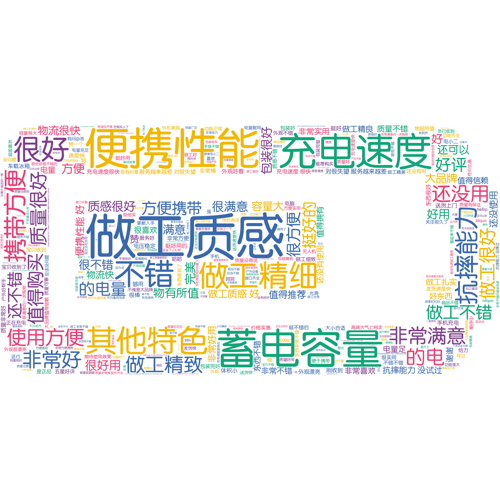

In [256]:
display_image('img/全体评价词云图.png', '全体评价词云图')

## 积极评价词云图

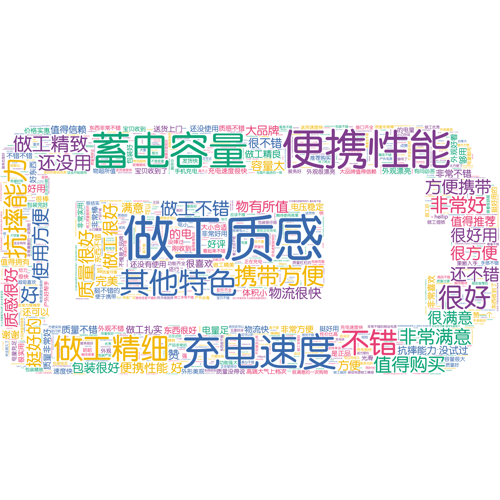

In [257]:
display_image('img/积极评价词云图.png', '积极评价词云图')

## 消极评价词云图

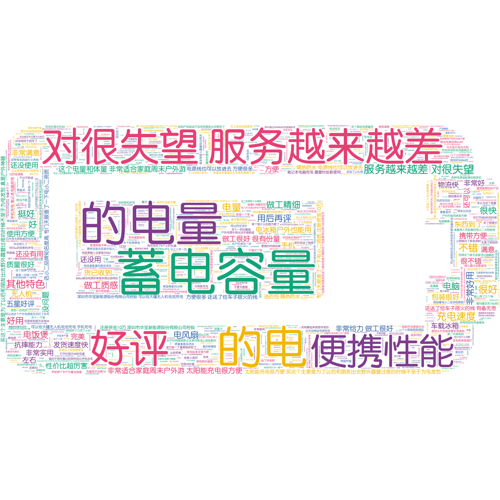

In [258]:
display_image('img/消极评价词云图.png', '消极评价词云图')

In [259]:
# 查看具体的负面评价原文
neg_list[-1:-5:-1]

['反应问题客服完全不理，客服不诚信，附件没给全不说，答应给的充电宝也没给',
 '服务态度很差',
 '买贵了，才知道所谓的30天保价会因为有赠品而不能保价？\r\n半天也联系不到售后客服。。呵呵，电小二的售后服务就是没有服务！',
 '对很失望，服务越来越差!对很失望，服务越来越差!对很失望，服务越来越差!对很失望，服务越来越差!对很失望，服务越来越差!对很失望，服务越来越差!逃离!把我一个VIP老客户变成了差评师!售后太差！在上花费的那些钱给人和那些#商家买纸钱吧！']

### 小结：
- **正面/积极评价的关注点在于“做工质感”，“便携性能“，”蓄电容量“，”充电速度“，“抗摔能力”**
- **负面/消极评价的关注点在于“服务“**

### 潜在问题：
- **根据消极情绪的词云图和混淆举证的得分反映出SnowNLP对长句或复合句的情感极性判读的准确率（80.4%）有待提升，可以通过以下方法解决：**  
    **- 建立自定义电商评论情感词词典**  
    **- 用更多相关语料来定制化训练模型**

## 4- 关键信息提取

### 4.1 TextRank关键词提取

对全文进行TextRank主题词提取，输出Top20个主题词及其权重。

In [260]:
# 文本预处理
def preprocess(texts):
    # 分词
    jieba.suggest_freq('电小二', True)  # 对于“电小二”关键词强制不分词
    segmented = pd.Series(texts).apply(lambda x: list(jieba.cut(x, cut_all=True)))
    # 加载停用词表
    stop_words = pd.read_csv('data/stopwords.txt', sep='yang', encoding='utf-8', header=None)[0]
    # 过滤停用词和标点符号
    preprocessed = segmented.apply(lambda x: [i.strip() for i in x if i not in stop_words and i.strip() != ''])
    # 去除标点符号
    for i in range(len(preprocessed)):
        preprocessed[i] = [word for word in preprocessed[i] if not re.match("[\u4e00-\u9fa5]", word) is None]
    return preprocessed

In [261]:
txt_preprocessed = preprocess(txt_list)

In [262]:
res = jieba.analyse.textrank(full_txt, topK=100, withWeight=True, allowPOS=('ns', 'n', 'vn', 'v', 'nr', 'nrt', 'z', 'r', 'x'))
words=[]
weights=[]
for word, weight in res[:20]:
    words.append(word)
    weights.append(weight)
    print('%s %.4f'%(word, weight)) 

充电 1.0000
做工 0.8218
电源 0.5627
使用 0.4650
质感 0.4056
速度 0.3905
没有 0.3146
电小二 0.3045
这个 0.3000
容量 0.2854
质量 0.2577
问题 0.2483
收到 0.2481
小时 0.2394
蓄电 0.2348
电量 0.2294
外观 0.2170
客服 0.2113
值得 0.2021
满意 0.1973


**Top20关键词分别是 {充电，做工，电源，使用，质感，速度，没有，电小二，这个，容量，质量，问题，收到，小时，蓄电，电量，外观，客服，值得，满意}**

**高频词汇中除了词云图中出现的词外，“外观”和“质量”也进入了前排，说明除了质量这个硬指标，外观颜值也是消费者够买电小二的重要关注点。**

**“满意”一词的高频程度，说明不少消费者对电小二的总体满意度较高。**

### 4.2 LDA主题分析

In [263]:
import gensim
import string
import logging

from gensim import models,corpora
# 屏蔽gensim训练的日志打印
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)',
                    level=logging.INFO)

In [264]:
pos_preprocessed = preprocess(pos_list)
neg_preprocessed = preprocess(neg_list)
pos_preprocessed[:2]

0    [宝贝, 贝特, 特别, 喜欢, 颜, 值, 高质, 高质量, 质量, 好, 中, 看, 又...
1    [做工, 精细, 轻巧, 便利, 外观, 外观设计, 设计, 感, 来说, 非常, 满意, ...
dtype: object

In [265]:
def lda_analysis(data):
    dictionary = corpora.Dictionary(data) # 建立词典
    corpus = [dictionary.doc2bow(i) for i in data] # 建立语料库
    lda = models.LdaModel(corpus, num_topics = 3, id2word = dictionary, 
                          passes=10, iterations=50, alpha='symmetric', eta='symmetric') # LDA 模型训练
                                           
    for i in range(3):
        print("主题%d : " %i)
        print(lda.print_topic(i)) # 输出每个主题

print('正面主题分析')
lda_analysis(pos_preprocessed)

2023-04-21 14:21:45.862 adding document #0 to Dictionary<0 unique tokens: []>
2023-04-21 14:21:45.888 built Dictionary<2829 unique tokens: ['不要', '中', '中用', '了', '值']...> from 782 documents (total 17282 corpus positions)
2023-04-21 14:21:45.889 Dictionary lifecycle event {'msg': "built Dictionary<2829 unique tokens: ['不要', '中', '中用', '了', '值']...> from 782 documents (total 17282 corpus positions)", 'datetime': '2023-04-21T14:21:45.889316', 'gensim': '4.2.0', 'python': '3.7.7 (default, Mar 23 2020, 17:31:31) \n[Clang 4.0.1 (tags/RELEASE_401/final)]', 'platform': 'Darwin-21.6.0-x86_64-i386-64bit', 'event': 'created'}
2023-04-21 14:21:45.901 using symmetric alpha at 0.3333333333333333
2023-04-21 14:21:45.901 using symmetric eta at 0.3333333333333333
2023-04-21 14:21:45.902 using serial LDA version on this node
2023-04-21 14:21:45.904 running online (multi-pass) LDA training, 3 topics, 10 passes over the supplied corpus of 782 documents, updating model once every 782 documents, evaluating 

正面主题分析


2023-04-21 14:21:46.313 -8.702 per-word bound, 416.6 perplexity estimate based on a held-out corpus of 782 documents with 17282 words
2023-04-21 14:21:46.314 PROGRESS: pass 0, at document #782/782
2023-04-21 14:21:46.658 topic #0 (0.333): 0.024*"的" + 0.018*"了" + 0.013*"不错" + 0.013*"还" + 0.012*"好" + 0.011*"使用" + 0.011*"很" + 0.010*"充电" + 0.009*"可以" + 0.006*"做工"
2023-04-21 14:21:46.659 topic #1 (0.333): 0.026*"的" + 0.023*"好" + 0.018*"做工" + 0.017*"了" + 0.016*"很" + 0.015*"方便" + 0.013*"不错" + 0.012*"非常" + 0.010*"电源" + 0.010*"使用"
2023-04-21 14:21:46.660 topic #2 (0.333): 0.035*"的" + 0.028*"很" + 0.021*"好" + 0.020*"了" + 0.018*"不错" + 0.016*"做工" + 0.014*"充电" + 0.012*"用" + 0.010*"也" + 0.010*"质感"
2023-04-21 14:21:46.660 topic diff=1.623332, rho=1.000000
2023-04-21 14:21:46.962 -6.954 per-word bound, 123.9 perplexity estimate based on a held-out corpus of 782 documents with 17282 words
2023-04-21 14:21:46.963 PROGRESS: pass 1, at document #782/782
2023-04-21 14:21:47.191 topic #0 (0.333): 0.024*"的" +

主题0 : 
0.025*"的" + 0.019*"了" + 0.015*"还" + 0.014*"不错" + 0.014*"使用" + 0.008*"后" + 0.007*"充电" + 0.007*"有" + 0.007*"可以" + 0.006*"没有"
主题1 : 
0.030*"好" + 0.029*"的" + 0.023*"很" + 0.017*"非常" + 0.017*"方便" + 0.016*"做工" + 0.016*"了" + 0.014*"不错" + 0.013*"电源" + 0.011*"质量"
主题2 : 
0.032*"的" + 0.025*"很" + 0.020*"了" + 0.020*"好" + 0.018*"做工" + 0.016*"不错" + 0.016*"充电" + 0.013*"质感" + 0.011*"用" + 0.011*"便携"


In [266]:
print('负面主题分析')
lda_analysis(neg_preprocessed)

2023-04-21 14:21:50.608 adding document #0 to Dictionary<0 unique tokens: []>
2023-04-21 14:21:50.618 built Dictionary<1969 unique tokens: ['不', '不过', '了', '些', '以为']...> from 210 documents (total 7255 corpus positions)
2023-04-21 14:21:50.619 Dictionary lifecycle event {'msg': "built Dictionary<1969 unique tokens: ['不', '不过', '了', '些', '以为']...> from 210 documents (total 7255 corpus positions)", 'datetime': '2023-04-21T14:21:50.619788', 'gensim': '4.2.0', 'python': '3.7.7 (default, Mar 23 2020, 17:31:31) \n[Clang 4.0.1 (tags/RELEASE_401/final)]', 'platform': 'Darwin-21.6.0-x86_64-i386-64bit', 'event': 'created'}
2023-04-21 14:21:50.623 using symmetric alpha at 0.3333333333333333
2023-04-21 14:21:50.624 using symmetric eta at 0.3333333333333333
2023-04-21 14:21:50.625 using serial LDA version on this node
2023-04-21 14:21:50.626 running online (multi-pass) LDA training, 3 topics, 10 passes over the supplied corpus of 210 documents, updating model once every 210 documents, evaluating pe

负面主题分析


2023-04-21 14:21:50.847 topic #0 (0.333): 0.022*"的" + 0.015*"了" + 0.011*"用" + 0.009*"电源" + 0.008*"也" + 0.008*"好" + 0.007*"户外" + 0.007*"很" + 0.007*"充电" + 0.006*"是"
2023-04-21 14:21:50.848 topic #1 (0.333): 0.031*"了" + 0.030*"的" + 0.013*"好" + 0.011*"很" + 0.011*"用" + 0.010*"充电" + 0.008*"就" + 0.008*"也" + 0.008*"电源" + 0.008*"可以"
2023-04-21 14:21:50.849 topic #2 (0.333): 0.033*"的" + 0.020*"了" + 0.015*"充电" + 0.015*"用" + 0.009*"还" + 0.007*"买" + 0.007*"好" + 0.007*"很" + 0.007*"可以" + 0.007*"电源"
2023-04-21 14:21:50.849 topic diff=1.314779, rho=1.000000
2023-04-21 14:21:50.929 -7.150 per-word bound, 142.0 perplexity estimate based on a held-out corpus of 210 documents with 7255 words
2023-04-21 14:21:50.930 PROGRESS: pass 1, at document #210/210
2023-04-21 14:21:50.985 topic #0 (0.333): 0.021*"的" + 0.014*"了" + 0.010*"用" + 0.009*"电源" + 0.008*"户外" + 0.007*"小二" + 0.007*"很" + 0.007*"也" + 0.007*"好" + 0.006*"给"
2023-04-21 14:21:50.985 topic #1 (0.333): 0.030*"了" + 0.029*"的" + 0.014*"好" + 0.012*"很" + 0.01

主题0 : 
0.019*"的" + 0.013*"了" + 0.010*"电源" + 0.009*"户外" + 0.008*"小二" + 0.007*"很" + 0.006*"用" + 0.006*"给" + 0.006*"电" + 0.006*"方便"
主题1 : 
0.028*"了" + 0.028*"的" + 0.015*"好" + 0.014*"很" + 0.013*"用" + 0.010*"也" + 0.009*"充电" + 0.008*"就" + 0.008*"使用" + 0.007*"是"
主题2 : 
0.035*"的" + 0.023*"了" + 0.016*"充电" + 0.015*"用" + 0.009*"电源" + 0.008*"买" + 0.008*"还" + 0.008*"我" + 0.008*"可以" + 0.007*"好"


**LDA主题模型结果没能挖掘电小二评价文本中的潜在主题，由于正面评论和负面评论的三个主题之间交集较多，说明主题分离的效果不好，无法进一步洞悉有效的主题。**

## 5- 共现语义网络

- 复杂语义网络还可以用<u>**Rost.CM6，Gephi或者Neo4j**</u>软件自动化构建

### 5.1 词频统计

In [267]:
import networkx as nx  #复杂网络分析库
import collections # 词频统计库
import jieba.posseg as pseg
from pyecharts.charts import Graph

In [268]:
num=40
G=nx.Graph()

In [269]:
# 读取文件
fn = open('data/comment.txt',encoding='utf-8') 
string_data = fn.read() 
fn.close() 

pattern = re.compile(u'\t|\.|-|:|;|\)|\(|\?|，|！|。|、|：|0|1|7|"') 
string_data = re.sub(pattern, '', string_data)    

jieba.add_word("电小二")
seg_list_exact = jieba.cut(string_data)
object_list = []

with open('data/stopwords.txt','r',encoding='utf-8') as file2:
    remove_words=" ".join(file2.readlines()) 
    
for word in seg_list_exact: 
    if word not in remove_words: 
        object_list.append(word) # 分词追加到列表

In [270]:
# 词频统计
word_counts = collections.Counter(object_list) # 对分词做词频统计
word_counts_top = word_counts.most_common(num) # 获取最高频的词
word = pd.DataFrame(word_counts_top, columns=['关键词','次数'])

word_T = pd.DataFrame(word.values.T,columns=word.iloc[:,0])
net = pd.DataFrame(np.mat(np.zeros((num,num))),columns=word.iloc[:,0])

k = 0

### 5.2 构建语义关联矩阵

下面这一步的加载时间较长, 事先将输出的矩阵信息保存为“semantic_matrix.pkl”文件

In [271]:
# for i in range(len(string_data)):
#     if string_data[i] == '\n':  #根据换行符读取一段文字
#         seg_list_exact = jieba.cut(string_data[k:i], cut_all = False) # 精确模式分词
#         object_list2 = []
#         for words in seg_list_exact: # 循环读出每个分词
#             if words not in remove_words: # 如果不在去除词库中
#                 object_list2.append(words) # 分词追加到列表
# word_counts2 = collections.Counter(object_list2)
# word_counts_top2 = word_counts2.most_common(num) # 获取该段最高频的词
# word2 = pd.DataFrame(word_counts_top2)
# word2_T = pd.DataFrame(word2.values.T,columns=word2.iloc[:,0])
# relation = list(0 for x in range(num))
# # 查看该段最高频的词是否在总的最高频的词列表中
# for j in range(num):
#     for p in range(len(word2)):
#         if word.iloc[j,0] == word2.iloc[p,0]:
#             relation[j] = 1
#             break
#         #对于同段落内出现的最高频词，根据其出现次数加到语义关联矩阵的相应位置
# for j in range(num):
#     if relation[j] == 1:
#         for q in range(num):
#             if relation[q] == 1:
#                 net.iloc[j, q] = net.iloc[j, q] + word2_T.loc[1, word_T.iloc[0, q]]
#     k = i + 1
    
# with open('data/semantic_matrix.pkl', 'wb') as f:
#     pickle.dump(net, f)

上面这一步的加载时间较长

### 5.3 绘制语义网络图

这里直接读取事先保存的共现矩阵信息

In [272]:
with open('data/semantic_matrix.pkl', 'rb') as f:
    net = pickle.load(f)

In [273]:
# 准备绘图
n = len(word)
nodes = [{"name": word.iloc[i, 0]} for i in range(n)]
links = []
# 边的起点，终点，权重
for i in range(n):
    for j in range(i, n):
        if i != j:
            links.append({"source": word.iloc[i, 0], "target": word.iloc[j, 0], "value": net.iloc[i, j]})

# 绘图
c = (
    Graph()
    .add(
        "",
        nodes=nodes,
        links=links,
        layout="force",
        edge_symbol=["none", "arrow"],
        edge_symbol_size=6,
        label_opts=opts.LabelOpts(is_show=True), # 显示所有节点的内容
        linestyle_opts=opts.LineStyleOpts(width=0.5, curve=0.3, opacity=0.7),
    )
    .set_global_opts(title_opts=opts.TitleOpts(title="电小二共现语义网络（有向）"))
)
# 下图是动态渲染的语义网络
c.render_notebook()

In [274]:
# 由于是动态熏染图，也可以在html中查看
c.render("img/电小二共现语义网络.html")

'/Users/xiaojun/Desktop/cv/huabaoxinneng/Dxpower_comment_analysis/img/电小二共现语义网络.html'

### 小结：
**由于关键词之间的连线越多，说明共现的次数越多，发现**
- **比如“外观”这个积极情感词主要指向了“精致”，“精细”和“品牌”，说明外观可以作为消费者对电小二品牌忠诚度的考量因素**
- **比如“车载”主要指向了“太阳能”和“活动”，暗示消费者在户外活动时由于车载设备的大量充电需求，有购买太阳能配件的倾向性**

## 6-总结和其他分析角度

### 6.1 总结

根据对京东平台上**电小二（Dxpower） 户外电源600W大功率220V移动便携大容量电脑充电宝露营应急备用储能电源（型号：户外电源500W ）** 的消费者评价情况进行多维度的分析，得出以下4点结论:  
 
**1 消费者对电小二在做工质感、便携程度、蓄电容量、充电速度量、抗摔能力等方面满意度高**

**2 电小二在售前和售后服务质量上仍有改善空间。可以通过提升智能客服机器人的回复精准度，对差评用户进行人工回访，以提升品牌口碑**

**3 电小二可以进一步提升在外观设计上的研发，以进一步提升其品牌忠诚度**

**4 电小二可以进一步探索不同储能设备和太阳能配件捆绑销售的组合营销策略**


### 6.2 其他潜在分析角度 

**1- 话题聚类：**
- 通过kmeans聚类，尝试将评论信息归纳为若干话题

**2- 用户画像/用户分层（RFM模型）**  
- 在拥有消费者的**基本人口统计信息（如性别、年龄、教育水平），地理位置信息，兴趣爱好信息，消费行为信息（包括消费者的购买历史、购买渠道、购买频率、购买金额）,社交媒体信息等** 的前提下，来建立消费者的用户画像，了解他们的兴趣、偏好和行为模式，以帮助电小二品牌更好地了解他们的目标市场，并针对性地进行市场推广和产品开发  
- RFM用户分层模型通过用户历史消费数据，以三维坐标系（最近消费时间（R）、消费频次（F）、消费金额（M））来进行用户价值分析

**3- 关联分析**
- 通过分析商品型号与用户评价之间的关系，可以发现不同型号的商品在用户心目中的位置，帮助电小二了解市场需求并根据需求调整产品的研发方向

**4- 竞品分析**
- 对竞争对手的评论数据来对电小二在服务、价格、销售策略等方面的优势和劣势

© 2023 魏筱鋆 (Jessie Wei). All rights reserved.